<b><font size="6">Data-Driven Marketing with Google Merch Store Customer Data</font>

    Notebook by Allison Kelly - allisonkelly42@gmail.com

    Blog post - placeholder

    Presentation - placeholder

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Customer-Lifetime-Value-and-Customer-Attrition-Prediction" data-toc-modified-id="Customer-Lifetime-Value-and-Customer-Attrition-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customer Lifetime Value and Customer Attrition Prediction</a></span><ul class="toc-item"><li><span><a href="#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtaining the data</a></span></li><li><span><a href="#Cleaning-the-Data" data-toc-modified-id="Cleaning-the-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cleaning the Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Market-Segmentation-and-the-RFM-Model" data-toc-modified-id="Market-Segmentation-and-the-RFM-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Market Segmentation and the RFM Model</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Modeling</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Introduction

Leveraging machine learning and AI with the massive amounts of consumer history, web traffic, and product reviews can have a measurable impact on marketing campaigns. By harnessing the power of statistical and analytical tools, patterns untracked by basic dashboards can be unearthed, translating into higher conversion rates over traditional marketing strategies. The following notebook is one such demonstration of this power.

Part one explores customer purchase history on the <a href="https://shop.googlemerchandisestore.com/">Google Merchandise Store.</a> By using machine learning, I will predict the customer lifetime value (CLV) of each customer. This data can then be used to segment ads, email marketing campaigns, and other traditional marketing ventures. I will also predict and measure customer attrition which can be used to develop proactive prevention strategies and increase revenue. 

Part two uses NLP to parse through Google Play store app reviews, conduct sentiment analysis, and classify reviews. The NLP machine learning models can be used to recommend apps and get feedback in realtime to prompt bug fixes and improvements. You'll find this in a separate notebook <b>here.</b> 

Finally, part three will focusing on tracking important metrics and gleaning insights from the Google Analytics demo account for the Google Merchandise Store. Setting benchmarks for KPIs and tracking campaign results are essential to understanding consumer behavior and making informed business decisions. PLACEHOLDER FOR WHERE THIS CAN BE FOUND

# Imports

In [24]:
import pandas as pd

# Plot data
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import time
import datetime
import numpy as np
import json # for data cleaning

import warnings # Ignoring warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Customer Lifetime Value and Customer Attrition Prediction

In marketing, according to <a href="https://en.wikipedia.org/wiki/Customer_lifetime_value">Wikipedia</a>, Customer Lifetime Value (CLV) can be defined as "a prediction of the net profit attributed to the entire future relationship with a customer." CLV is an important metric to track as it can help identify your customer acquisition budget, help your marketing team to segment your customer base, increase retention and satisfaction, etc. CLV is represented as a dollar amount and varies customer to customer. 

<img src="brandwise-clv-bellcurve.gif">

## Obtaining the data

This dataset was derived from the Google Merchandise Store demo account as provided by Google BigQuery on Kaggle. You can find the data <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction">here.</a> 

In [ ]:
df = pd.read_csv('train.csv') # loading and checking out the dataset
df.head()

In [ ]:
print(df.info())

print('\n\nNumber of individual visitors to the Google Merch Store: ', 
      len(df.fullVisitorId.unique()))

The dataframe is consisted of 903,653 datapoints describing visits to the Google Merch Store with 742,753 unique visitors. Most features consist of objects, though the integers are either dates, times or immutable ID numbers that should be categorized accordingly. 

## Cleaning the Data

In [ ]:

def datetime_edits(dataframe):
    
    """This function changes the two columns 
    with dates/times into datetime objects.
    To be used with dataframes with similar
    setup to this one."""
    
    try:
        dataframe.date.astype(str)
        dataframe.date = pd.to_datetime(dataframe.date, 
                                        format='%Y%m%d')
    except:
        print("Your dataframe does not contain a 'date' column.")
        
    try:
        dataframe.visitStartTime = pd.to_datetime(dataframe.visitStartTime, unit='s')
    
    except:
        print("Your dataframe does not containt a 'visitStartTime' column.")
    
    # confirming proper edits were made
    return "Date column:", dataframe.date.dtype, "Time column:", dataframe.visitStartTime.dtype


In [ ]:
datetime_edits(df)

In [ ]:
# changing immutable IDs to strings
df.visitId = df.visitId.astype(str)

In [ ]:

def unpack_col(df, col):
    
    '''Some column values are dictionary-like strings.
    This function unpacks those values, creating new
    columns for each key that can then be analyzed 
    as separate features. Returns dataframe of 
    unpacked column, not including original column.
    '''
    
    df[col] = df[col].dropna().apply(json.loads)
    unpacked_df = df[col].apply(pd.Series)
        
    return unpacked_df
        
geo_df = unpack_col(df, 'geoNetwork')
totals_df = unpack_col(df, 'totals')


In [ ]:
df_expanded = pd.concat([df, geo_df, totals_df], axis=1)

In [ ]:
df_expanded.head()

In [ ]:
# Dropping unpacked columns 

df_expanded = df_expanded.drop('geoNetwork', axis=1)
df_expanded = df_expanded.drop('totals', axis=1)

The nested information in the device and trafficSource columns would be necessary for an analysis of ad quality, but we're concerned with what the customer does once they get to the store, not how they get there. We'll drop those columns as well. 

In [ ]:
df_expanded = df_expanded.drop(['device', 'trafficSource'], axis=1)

In [ ]:

# Identifying columns that have no variation
cols = list(df_expanded.columns)

one_variant = []
for col in cols:
    if len(df_expanded[col].unique()) == 1:
        print(df_expanded[col].unique())
        one_variant.append(col)
one_variant

Columns with no variation in value will be dropped. Some columns in a full dataset such as language could be relevant to CLV, but since we don't have that information available through the Google Demo Account, we'll remove those columns. 

In [ ]:
df_expanded = df_expanded.drop(one_variant, axis=1)

Because our unique customer identifier is tied to 'fullVisitorId' and 'visitStartTime' describes the frequency (or lacktherof) of visits to the store, we can safely remove 'sessionId' and 'visitId'.

In [ ]:
df_expanded = df_expanded.drop(['visitId', 'sessionId'], axis=1)

Columns 'region,' 'metro,' and 'city' may have an impact on whether or not a customer will spend in the future and how much due to income levels and cost of living, however most of the information in these categories is not available. We'll drop these columns for this project, though you may consider leaving them if other datasets give a more detailed look into the customers location. We can also drop 'continent' and 'subcontinent' because the country names themselves give us that information inherently. 

In [ ]:
# Only keeping country column to identify location of transaction
df_expanded = df_expanded.drop(['region', 'metro', 'city', 'continent', 'subContinent' ], axis=1)

In [ ]:
# Removing parentheses around "Other" channel group
df_expanded.channelGrouping = df_expanded.channelGrouping.str.strip('()')

Finally, we'll drop the 'networkDomain' column as it doesn't pertain to the prediction of CLV. 

In [ ]:
df_expanded.drop('networkDomain', axis=1, inplace=True)

In [ ]:
df_expanded.isna().any()

In [ ]:
# Replacing a variant of NaN with 'Unknown'
df_expanded = df_expanded.replace('(not set)', 'Unknown')

In [ ]:
nan_cols = ['pageviews', 'bounces', 'newVisits', 'transactionRevenue']
for col in nan_cols: 
    
    print(f'{col} NaN: ', df_expanded[col].isnull().sum())
    print(f'{col} datatype: ', df_expanded[col].dtype, '\n')

Each of the columns that contain null values are related to the customer's behavior once on the site. We can change the NaNs to 0 to indicate no pages were viewed, the customer did not bounce, the customer has been to the merch store previously, and the customer did not purchase from the store. We also need to correct the datatype of 'transactionRevenue' from object to float. 

In [ ]:
df_expanded.fillna('0', inplace=True)

In [ ]:
df_expanded.transactionRevenue = df_expanded.transactionRevenue.astype('float')

In [ ]:
for col in df_expanded.columns:
    print(df_expanded[col].value_counts().head())

In [ ]:
df_expanded.to_csv('cleaned_df.csv', index=False)

## Exploratory Data Analysis

In [ ]:
df = pd.read_csv('cleaned_df.csv')
df.head()

In [99]:
df.describe()

,visitNumber,hits,pageviews,bounces,newVisits,transactionRevenue,logRevenue
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,9.036530e+05,903653.000000
mean,2.264897,4.596538,3.849338,0.498676,0.778020,1.704273e+06,0.227118
std,9.283735,9.641437,7.025002,0.499999,0.415578,5.277866e+07,2.003710
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
50%,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
75%,1.000000,4.000000,4.000000,1.000000,1.000000,0.000000e+00,0.000000
max,395.000000,500.000000,469.000000,1.000000,1.000000,2.312950e+10,23.864375


The dataset is pulled through Google Analytics BigQuery, and according to the BigQuery cookbook, transaction revenue is in USD * 10^6. We'll need to add a negligable amount to each transaction (to avoid dividing by 0) and take the log of the transactionRevenue column before we proceed with data exploration.

In [100]:
df['logRevenue'] = np.log(df.transactionRevenue+1)

In [101]:
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,hits,pageviews,bounces,newVisits,transactionRevenue,logRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,1,1,1,1,0.0,0.0
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,1,1,1,1,0.0,0.0
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,1,1,1,1,0.0,0.0
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,1,1,1,1,0.0,0.0
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,1,1,1,0,0.0,0.0


In [102]:
purchase_df = df.loc[df.transactionRevenue > 0.0]

print('Our timeline begins: ', df.visitStartTime.min(), 'and ends: ', df.visitStartTime.max())
print(f'{len(purchase_df)} customers made purchases during that time period totalling {round(purchase_df.logRevenue.sum(),2)}')


Our timeline begins:  2016-08-01 07:00:12 and ends:  2017-08-02 06:59:53
11515 customers made purchases during that time period totalling 205236.02


The vast majority of visits to the Google Merch Store did NOT yield purchases.

In [103]:
round(purchase_df.logRevenue.max(),2)

23.86

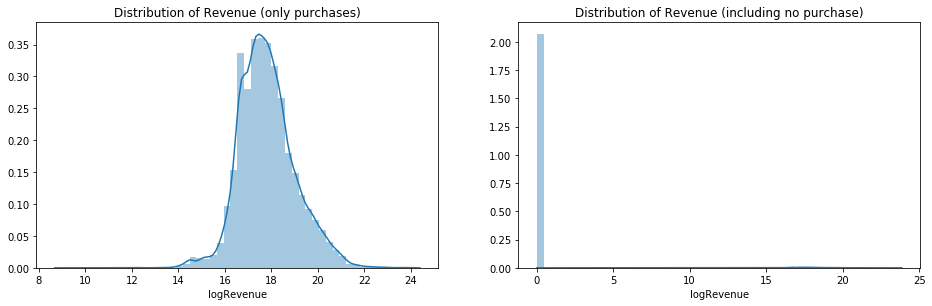

In [112]:
fig = plt.subplots(figsize=(13, 4))
plt.tight_layout()

plt.subplot(1, 2, 1)
sns.distplot(purchase_df.logRevenue)
plt.title(f"Distribution of Revenue (only purchases)")

plt.subplot(1, 2, 2)
sns.distplot(df.logRevenue)
plt.title(f"Distribution of Revenue (including no purchase)");

In [ ]:
plt.subplots(figsize=(15,8))

plt.subplot(1,2,1)
sns.violinplot(x='logRevenue', y='channelGrouping', data=purchase_df)
plt.title('Distribution of Purchase Revenue by Channel')

plt.subplot(1,2,2)
sns.violinplot(x='logRevenue', y='channelGrouping', data=df)
plt.title('Distribution of Purchase Revenue by Channel, including no purchase')

plt.tight_layout();

In [ ]:
df.date = pd.to_datetime(df.date)

In [ ]:
time_df = df.groupby(by=['date']).agg({'fullVisitorId':'count', 'transactionRevenue':'sum'})

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(time_df.index,time_df['transactionRevenue'])
plt.ylabel('Revenue')

plt.subplot(2,1,2)
plt.plot(time_df.index,time_df['fullVisitorId'])
plt.ylabel('Visits');

In [ ]:
country_df = df.groupby(by=['country']).agg({'fullVisitorId':'count', 'transactionRevenue':'sum'})

In [ ]:
top_ten_by_rev = country_df.sort_values('transactionRevenue', ascending=False).head(10)
top_ten_by_count = country_df.sort_values('fullVisitorId', ascending=False).head(10)

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.bar(top_ten_by_rev.index,np.log(top_ten_by_rev['transactionRevenue']))
plt.title('Top Ten Countries by Revenue')
plt.ylabel('Revenue (log)')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(top_ten_by_count.index,np.log(top_ten_by_count['fullVisitorId']))
plt.title('Top Ten Countries by Order Count')
plt.ylabel('Order Count')
plt.xticks(rotation=45);

In [ ]:
customer_df = purchase_df.groupby(by=['fullVisitorId']).agg({'visitNumber':'count', 'transactionRevenue':'sum'})

In [ ]:
customer_df = customer_df.loc[customer_df['visitNumber'] >1]

In [ ]:
print(f'{len(customer_df)} out of {len(purchase_df)} customers have made repeat purchases. ({round((len(customer_df)/len(purchase_df))*100)}% of customers)')

In [ ]:
print(f'The most orders made by a single customer: {customer_df.visitNumber.max()}')

## Market Segmentation and the RFM Model

In marketing, customer segmentation is the gold standard. As you understand your customers with precise detail, the more genuine your marketing rhetoric will come across. Generally, there are four ways to segment your consumer base: 

 - Demographic
 - Geographic
 - Psychographic
 - Behavioral
 
In order to supplement the web data we have from the Google Merchandise Store, we'll engineer a few features in order to 'score' each customer based on the RFM model. This technique takes the recency (R) of the last purchase, the frequency (F) of all purchases, and the monetary value (M) defined by the revenue of each customer. 

<img src="RFM.png">

Further down, we'll be using the sklearn's KMeans clustering algorithm to segment the customers. Depending on the busines objective, of which we don't have, we could have a set amount of segments to identify. For our purposes in this notebook, we'll try a technique to identify the optimal number of segments by finding the lowest sum of squared errors. 
 
*It's worth it to note that the data may NOT have identifiable clusters. Work with the data you have and make decisions that best suit the stakeholder's needs while not looking for information that isn't there.

In [3]:
# Importing cleaned dataset
df = pd.read_csv('cleaned_df.csv')
df.fullVisitorId = df.fullVisitorId.astype(str)
df['logRevenue'] = np.log(df.transactionRevenue+1)

In [51]:

def RFM_dataframe(customer_col, purchase_date_col, revenue_col, df):
    '''
    This function takes in a previously cleaned
    dataframe and the column names for customers, 
    purchase dates, and revenue as strings.
    Returns dataframe with two engineerd columns: 
    recency, and frequency, as well as a cumulative
    revenue total for each unique
    visitor to the Google Merch Store.
    '''
    
    # Select only unique customer IDs
    cust_df = df.groupby(customer_col)
    cust_df = pd.DataFrame(df[customer_col].unique(), columns=[customer_col])
    cust_df[customer_col].astype(str)
    
    # Create Dataframe of unique visitors and most recent visit to site
    df_recency = df.groupby(customer_col)[purchase_date_col].max().reset_index()
    df_recency.columns = [customer_col,purchase_date_col]
    df_recency[purchase_date_col] = pd.to_datetime(df_recency[purchase_date_col])
    df_recency['Recency'] = (df_recency[purchase_date_col].max() - df_recency[purchase_date_col]).dt.days
    df_recency = df_recency.drop(purchase_date_col, axis=1)
    df_recency['Recency'].astype('int')
    
    # Get visit counts for each user and create dataframe
    df_frequency = df.groupby(customer_col)[purchase_date_col].count().reset_index()
    df_frequency.columns = [customer_col,'Frequency']
    
    # Get total order revenue for each unique visitor 
    df_revenue = df.groupby(customer_col)[revenue_col].sum().reset_index()
    
    # Merge data
    
    dfs = [df_frequency, df_recency, df_revenue]
    
    for e in dfs:
        cust_df = pd.merge(cust_df, e, on=customer_col)
        
    return cust_df

Above is a nifty function I created to take our cleaned dataset and engineer the necessary features for segmentation and returns a new dataframe with only the necessary features needed to segment customers using the RFM model.

In [6]:
cust_df = RFM_dataframe(df)

In [129]:
cust_df.head()

,fullVisitorId,Frequency,Recency,logRevenue
0,1131660440785968503,1,333,0.0
1,377306020877927890,1,333,0.0
2,3895546263509774583,1,333,0.0
3,4763447161404445595,1,333,0.0
4,27294437909732085,2,333,0.0


Without assuming Google's marketing plan, I've decided to segment only those who have previously purchased. It may be beneficial to dive deeper into the behaviors of those who have not made purchases such as number of pages visited, pages on which they bounced, etc. so that you might improve your chances of them completing purchases online.

In [173]:
purchases = cust_df.loc[cust_df.logRevenue >0]

As we saw earlier, the data was very skewed, so we'll take the natural log of our other two features to normalize.

In [174]:
purchases['Recency'] = np.log(purchases['Recency']+1)
purchases['Frequency'] = np.log(purchases['Frequency']+1)

Now that our data is ready to cluster, we'll test a few cluster levels and compare the sum of squared errors in an elbow plot to identify the best level to cluster each feature individually.

In [175]:

def SSE_plot(df, col_to_plot=False):
    '''
    This function takes in one column of
    the RFM dataframe as a string
    and will plot a KMeans elbow plot of the 
    sum of squared estimate. Where the elbow
    bends will determine how many clusters are
    optimal for the Kmeans clustering.
    '''
    sse={}
    if col_to_plot:
        km_var = df[[col_to_plot]].copy()
    else:
        km_var = df.copy()
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(km_var)
        km_var["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
#     plt.title(str(km_var))
    plt.show();
    

Frequency


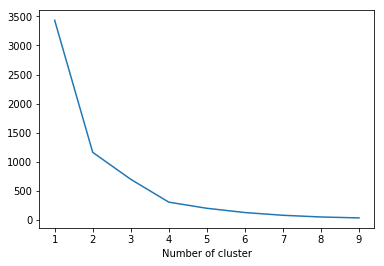

Recency


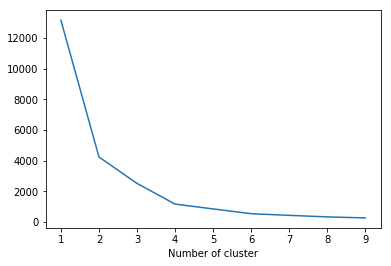

logRevenue


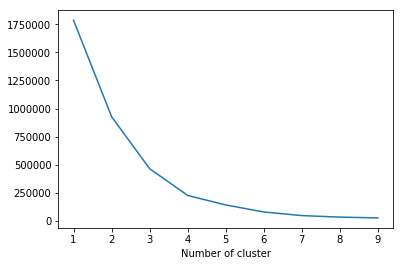

In [176]:
%matplotlib inline
for col in ['Frequency', 'Recency', 'logRevenue']:
    print(col)
    SSE_plot(purchases, col)

In [177]:

def order_cluster(cluster_col, feature_col, df, ascending):
    '''
    This function takes in a column of cluster
    assignments and features used to assign the 
    cluster as strings, dataframe in which clusters
    are featured, and ascending argument. Returns 
    dataframe with clusters ordered from worst to best.
    '''
    
    df_new = df.groupby(cluster_col)[feature_col].mean().reset_index()
    df_new = df_new.sort_values(by=feature_col,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_col,'index']], on=cluster_col)
    df_final = df_final.drop([cluster_col],axis=1)
    df_final = df_final.rename(columns={"index":cluster_col})
    return df_final

Below, we'll cluster based on the number identified by the SSE plots. We'll use the function above to order the clusters from worst to best and view basic statistics of each feature's cluster.

In [182]:
frequency_kmeans = KMeans(n_clusters=4)
frequency_kmeans.fit(purchases[['Frequency']])

# Assigning cluster prediction to customers
purchases['FrequencyCluster'] = frequency_kmeans.predict(purchases[['Frequency']])

# Ordering clusters from low to high and identifying statistics
purchases = order_cluster('FrequencyCluster', 'Frequency',purchases,True)
purchases.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3232.0,0.693147,1.110395e-16,0.693147,0.693147,0.693147,0.693147,0.693147
1,3732.0,1.210694,1.403099e-01,1.098612,1.098612,1.098612,1.386294,1.386294
2,2396.0,1.813461,1.990027e-01,1.609438,1.609438,1.791759,1.945910,2.197225
3,670.0,2.684826,4.425648e-01,2.302585,2.397895,2.564949,2.890372,5.631212


In [187]:
recency_kmeans = KMeans(n_clusters=4)
recency_kmeans.fit(purchases[['Recency']])

# Assigning cluster prediction to customers
purchases['RecencyCluster'] = recency_kmeans.predict(purchases[['Recency']])

# Ordering clusters from low to high and identifying statistics
purchases = order_cluster('RecencyCluster', 'Recency',purchases,False)
purchases.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5520.0,5.525373,0.240259,5.017280,5.356586,5.513429,5.736572,5.902633
1,2907.0,4.505547,0.324144,3.828641,4.276666,4.532599,4.779123,5.010635
2,1174.0,3.134230,0.457627,2.197225,2.772589,3.135494,3.555348,3.806662
3,429.0,1.169868,0.727823,0.000000,0.693147,1.386294,1.791759,2.079442


In [184]:
revenue_kmeans = KMeans(n_clusters=5)
revenue_kmeans.fit(purchases[['logRevenue']])

# Assigning cluster prediction to customers
purchases['RevenueCluster'] = revenue_kmeans.predict(purchases[['logRevenue']])

# Ordering clusters from low to high and identifying statistics
purchases = order_cluster('RevenueCluster', 'logRevenue',purchases,True)
purchases.groupby('RevenueCluster')['logRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,9084.0,17.679047,1.134271,9.210440,16.906098,17.599246,18.326425,27.995666
1,847.0,39.486561,7.473095,30.886037,35.073167,36.687241,39.152788,65.669430
2,87.0,92.431287,22.725313,66.048770,74.673787,84.919186,103.605626,158.931070
3,11.0,233.683318,62.057712,167.865328,184.178069,203.469336,284.660350,336.619337
4,1.0,582.402406,NaN,582.402406,582.402406,582.402406,582.402406,582.402406


<b>
- Frequency: </b> Nearly 70% of the customers fall in the lower two clusters and there's a large gap between the minimum and maximum values of the high value cluster. 


<b>
- Recency: </b> Most customers are quite inactive (how many Google tees do you <i>really</i> need?) The window of recency gets larger the better the cluster assignment is.  

<b>
- Revenue: </b> The vast majority of consumers purchased, on average, 17 dollars worth of products on the Google Merchandise Store. Only 10 percent of consumers purchased more than 30 dollars worth of products with one person spending nearly 600 dollars.

In [185]:
# Adding cluster numbers to identify overall score per customer
purchases['OverallScore'] = purchases['RecencyCluster'] + purchases['FrequencyCluster'] + purchases['RevenueCluster']
purchases.groupby('OverallScore')['Recency','Frequency','logRevenue'].mean()

,Recency,Frequency,logRevenue
OverallScore,,,
0,5.538197,0.693147,17.486465
1,5.194417,1.040604,17.662253
2,4.805109,1.393419,18.642624
3,4.156084,1.645626,21.753934
4,3.597439,1.942669,25.657556
5,2.897217,2.206071,34.618688
6,2.285679,2.562774,48.468014
7,1.931743,2.803124,73.186554
8,1.400932,3.214805,146.255854


In [153]:
# Naming and defining segments
purchases['Segment'] = 0
purchases.loc[purchases['OverallScore']>2,'Segment'] = 1 
purchases.loc[purchases['OverallScore']>5,'Segment'] = 2 

Again, depending on your business model, you may already have certain cutoffs for segments. Here, I've broken them down to three groups. Inactive, infrequent, low spenders are low value, mid value is higher than average revenue with average - more than average recency and average to more than average frequency, and high value customers fall into the upper eschelons of at least two features. 

In [154]:
print('Low: ', len(purchases.query('Segment == 0')))
print('Mid: ', len(purchases.query('Segment == 1')))
print('High: ', len(purchases.query('Segment == 2')))

Low:  7336
Mid:  2517
High:  177


In [155]:
def scatter_plot(col1, col2, df):
    '''
    This function visualizes two features
    from the RFM dataframe and color codes
    each of the final clusters.'''
    
    plt.figure(figsize=(6,4))
    
    # Low Value Segment
    plt.scatter(x=df.query("Segment == 0")[col1],
               y=df.query("Segment == 0")[col2],
               c='#440154FF',
               alpha=.8)
    
    # Mid Value Segment
    plt.scatter(x=df.query("Segment == 1")[col1],
               y=df.query("Segment == 1")[col2],
               c='#20A387FF',
               alpha=.3)
    
    # High Value Segment
    plt.scatter(x=df.query("Segment == 2")[col1],
               y=df.query("Segment == 2")[col2],
               c='#FDE725FF',
               alpha=.5)
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} x {col2} Clusters')
    plt.show();

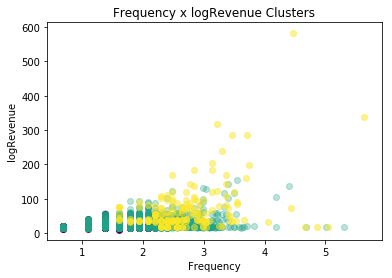

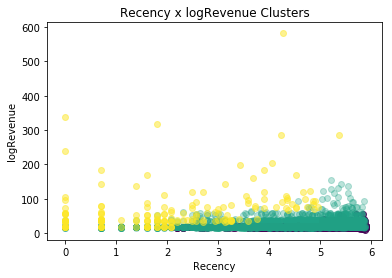

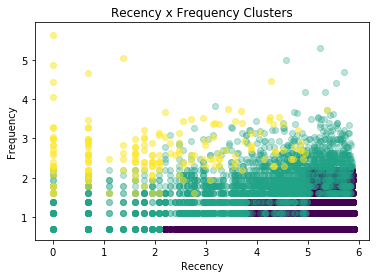

In [156]:
%matplotlib inline
scatter_plot('Frequency', 'logRevenue', purchases)
scatter_plot('Recency', 'logRevenue', purchases)
scatter_plot('Recency', 'Frequency', purchases)

The clusters look pretty well defined! It looks as if we were correct on our assumptions of the cluster levels. Below, we'll take a look at a 3D plot of the clusters to see behind the overlap. 

In [157]:
high = purchases.query('Segment == 2')
mid = purchases.query('Segment == 1')
low = purchases.query('Segment == 0')

<IPython.core.display.Javascript object>


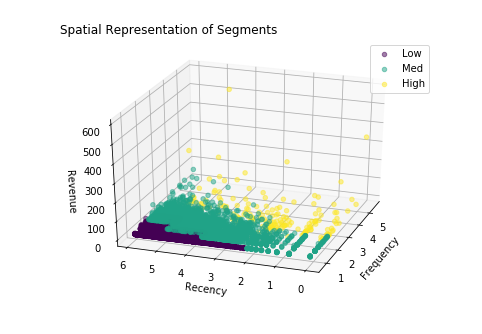

In [188]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1= (low['Frequency'].values, low['Recency'].values, low['logRevenue'].values)
g2 = (mid['Frequency'].values, mid['Recency'].values, mid['logRevenue'].values)
g3= (high['Frequency'].values, high['Recency'].values, high['logRevenue'].values)

data = [g1, g2, g3]
colors = ['#440154FF', '#20A387FF', '#FDE725FF']
groups = ['Low', 'Med', 'High']

for data, color, group in zip(data, colors, groups):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.5, c=color, label=group)

# Make legend
    ax.legend()
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Recency')
    ax.set_zlabel('Revenue')
    ax.set_title('Spatial Representation of Segments', loc='left')
    plt.show();

From this plot, we can see there are customers that have not spent a lot of money but frequently stop by the site and have made purchases recently that also fall into the high value category. Scores seem to be pulled down by either very infrequent purchases or made their last purchase far in the past. 

## Modeling

# Future Work